In [2]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs, stress_to_survival, survival_to_stress
from tqdm import tqdm
import plotly.graph_objects as go

In [3]:
# ignore = [
#     "huang_Flupyradifurone_2023",
#     "imrana_copper_2024",
#     "ayesha_chlorantran_2022_reference",
#     "ayesha_chlorantran_2022_agriculture",
#     "imrana_salt_2024",
#     "naemm_Clothianidin_2024_reference",
#     "imrana_2024_food",
# ]

ignore = [
    #     'bps_esf_food_2024',
    #    'ayesha-cloth_Clothianidin_2024_agricultural.xlsx',
    #    'huang_imidachloprid_2023.xlsx',
    #    'ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination.xlsx',
    #    'ayesha-cloth_Clothianidin_2024_reference_pre-contamination.xlsx',
    #    'naeem_Esfenvalerate_2019.xlsx',
]

# ignore = [
    
#     'imrana_salt_2024',
#        'ayesha_chlorantran_2022_agriculture',
#        'huang_Flupyradifurone_2023',
#        'ayesha_chlorantran_2022_reference'
#        'imrana_2024_food',
#        'imrana_copper_2024',
#        "ayesha_chlorantran_2022_reference",
    
# ]

filter_func = lambda path: not any(i in path for i in ignore)

In [4]:
def predict_cleaned_curv(data : ExperimentData):
    
    
    
    concentration = pad_c0(data.main_series.concentration).copy()
    survival_tox_observerd = np.copy(data.main_series.survival_rate / data.meta.max_survival)
    
    if data.meta.hormesis_concentration is None:
    
        hormesis_index = detect_hormesis_index(survival_tox_observerd)
        
        if hormesis_index is None:
            hormesis_index = 1
    
    else:
        hormesis_index = np.argwhere(data.meta.hormesis_concentration == data.main_series.concentration)[0,0]
    
    func, _, popt = pred_surv_without_hormesis(concentration=concentration, surv_withhormesis=survival_tox_observerd, hormesis_index=hormesis_index)
    
    return func, hormesis_index, popt

In [5]:
def gen_func(stress, cleaned_func):
    
    def func(x, stress):
        
        y = cleaned_func(x)
        
        stress = survival_to_stress(y) + stress
        
        return stress_to_survival(stress)
        
    return np.vectorize(lambda x: func(x,  stress = stress))

def find_lc_brentq(func, lc, min_v = 1e-8, max_v = 100000):
    
    
    left_val = func(min_v)
    lc = (100 - lc) / 100 * left_val
    
    brent_func = lambda x : func(x) - lc
    
    return brentq(brent_func, min_v, max_v)

In [6]:
stresses = np.linspace(0, 0.6, 100)


def compute_lc_trajectory(path: str):

    data = read_data(path)

    cfg = FitSettings(
        survival_max=data.meta.max_survival,
        param_d_norm=True,
    )

    fit = dose_response_fit(data.main_series, cfg)
    cleaned_func, hormesis_index, popt = predict_cleaned_curv(data)

    x = fit.concentration_curve

    lcs = []

    for stress in stresses:

        func = gen_func(stress, cleaned_func=fit.model)

        lcs.append(
            (
                find_lc_brentq(func, 10, max_v=x.max()),
                find_lc_brentq(func, 50, max_v=x.max()),
            )
        )

    return np.array(lcs)

results = {}

for path, _ in tqdm(load_files(filter_func)):
    
    results[path] = compute_lc_trajectory(path)

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


In [27]:
lc10 = np.array([i[:,0] for i in results.values()])
lc50 = np.array([i[:,1] for i in results.values()])
lc_10_frac = lc10[:,0][:,None] / lc10
lc_50_frac = lc50[:,0][:,None] / lc50

In [30]:
meta_infos = []
for _, data in load_files(filter_func):

    meta = data.meta
    meta_infos.append(
        {
            "Name":meta.title,
            "Chemical": meta.chemical,
            "Organism": meta.organism,
            "Experiment": data.meta.path.parent.name,
            "Duration": int(meta.days),
        }
    )
meta_infos = pd.DataFrame(meta_infos)
meta_infos["lc_10_frac"] = [np.array(a) for a in lc_10_frac]
meta_infos["lc_50_frac"] = [np.array(a) for a in lc_50_frac]
meta_infos.head()

,Name,Chemical,Organism,Experiment,Duration,lc_10_frac,lc_50_frac
0,2022 Ayesha-Chlorantran_reference,Chlrorantraniliprole,Gammarus pulex,2022 Ayesha-Chlorantran,2,"[1.0, 1.0091388194484097, 1.0183319707351464, ...","[1.0, 1.0196258022875015, 1.0391646254165783, ..."
1,2022 Ayesha-Chlorantran_agriculture,Chlrorantraniliprole,Gammarus pulex,2022 Ayesha-Chlorantran,2,"[1.0, 1.0131496673367448, 1.0262515256019131, ...","[1.0, 1.0146000634310532, 1.0291650707061928, ..."
2,"2021 Ayesha-Cloth, °C, Adap_reference",Clothianidin,Gammarus pulex,"2021 Ayesha-Cloth, °C, Adap",2,"[1.0, 1.0374671540993952, 1.075764935953207, 1...","[1.0, 1.034139974956245, 1.0690356751450962, 1..."
3,"2021 Ayesha-Cloth, °C, Adap_agricultural_pre-c...",Clothianidin,Gammarus pulex,"2021 Ayesha-Cloth, °C, Adap",2,"[1.0, 1.0636624264303762, 1.1306350733521788, ...","[1.0, 1.042385311363259, 1.0864643682235382, 1..."
4,"2021 Ayesha-Cloth, °C, Adap_reference_pre-cont...",Clothianidin,Gammarus pulex,"2021 Ayesha-Cloth, °C, Adap",2,"[1.0, 1.0536635588164756, 1.1096276636700357, ...","[1.0, 1.041629497710082, 1.0846467046871613, 1..."


In [107]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def gen_different_curves_fig():

    unique_experiments = meta_infos.Chemical.unique()
    palette = sns.color_palette(
        "Set2", len(unique_experiments)
    )  # Use a Seaborn color palette
    color_mapping = dict(zip(unique_experiments, palette.as_hex()))
    color_mapping["Mean"] = "black"
    color_mapping["Mean of All"] = "red"

    name_to_id = []

    fig = make_subplots(rows=1, cols=2)

    def gen_traces(y_key):
        ts = list()
        for _, row in meta_infos.iterrows():

            color = color_mapping[row.Chemical]
            ts.append(
                go.Scatter(
                    x=stresses,
                    y=row[y_key],
                    mode="lines",
                    name=row.Name,
                    line=dict(color=color),
                    hovertext=f"<br><b>Name</b>: {row.Name}<br><b>Experiment</b>: {row.Experiment}<br><b>Duration</b>: {row.Duration}<br><b>Main Stressor</b>: {row.Chemical}<br><b>Organism</b>: {row.Organism}",
                    showlegend=False,
                )
            )
            name_to_id.append(f"scatter_{row.Name}_{y_key}")
        return ts

    for i in gen_traces("lc_10_frac"):
        fig.add_trace(
            i,
            row=1,
            col=1,
        )
    for i in gen_traces("lc_50_frac"):
        fig.add_trace(
            i,
            row=1,
            col=2,
        )

    for chemical, color in color_mapping.items():
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode="lines",
                line=dict(color=color),
                name=chemical,  # Legend entry for each chemical
            )
        )
        name_to_id.append(f"color_{chemical}")

    cleaner = {
        "Chemical": "Main Stressor",
        "Experiment": "Experiment",
        "Duration": "Duration",
        "Organism": "Organism",
    }

    def gen_means(y_key):
        mean_curve = np.mean(np.stack(meta_infos[y_key].values), 0)

        yield go.Scatter(
            x=stresses,
            y=mean_curve,
            mode="lines",
            name="Mean",
            line=dict(color=color_mapping["Mean"]),
            showlegend=False,
        )
        name_to_id.append(f"mean_all_{y_key}")

        yield go.Scatter(
            x=stresses,
            y=mean_curve,
            mode="lines",
            name="Mean of All",
            line=dict(color=color_mapping["Mean of All"]),
            showlegend=False,
        )
        name_to_id.append(f"mean_reference_{y_key}")

        for key, label_name in cleaner.items():

            for val, df in meta_infos.groupby(key):
                mean_curve = np.mean(np.stack(df[y_key].values), 0)

                yield go.Scatter(
                    x=stresses,
                    y=mean_curve,
                    mode="lines",
                    name="Mean",
                    line=dict(color=color_mapping["Mean"]),
                    showlegend=False,
                )
                name_to_id.append(f"mean_{label_name} = {val}_{y_key}")

    for i in gen_means("lc_10_frac"):
        fig.add_trace(
            i,
            row=1,
            col=1,
        )
    for i in gen_means("lc_50_frac"):
        fig.add_trace(
            i,
            row=1,
            col=2,
        )

    fig.update_xaxes(title_text="Environmental Stress", row=1, col=1)
    fig.update_yaxes(
        title_text="Increase of Toxicant Sensitivity", type="log", row=1, col=1
    )
    fig.update_xaxes(title_text="Environmental Stress", row=1, col=2)
    fig.update_yaxes(
        title_text="Increase of Toxicant Sensitivity", type="log", row=1, col=2
    )

    def get_visible(df, name):
        valid = set()
        for n in df.Name.values:
            valid.add(f"scatter_{n}_lc_10_frac")
            valid.add(f"scatter_{n}_lc_50_frac")

        for chem in df.Chemical.unique():
            valid.add(f"color_{chem}")

        valid.add(f"color_Mean")
        valid.add(f"scatter_{n}_lc_10_frac")
        valid.add(f"scatter_{n}_lc_50_frac")
        if len(df) > 1:
            valid.add(f"mean_{name}_lc_10_frac")
            valid.add(f"mean_{name}_lc_50_frac")

        if name != "all":
            valid.add(f"color_Mean of All")
            valid.add(f"mean_reference_lc_10_frac")
            valid.add(f"mean_reference_lc_50_frac")

        for v in valid:
            assert v in name_to_id, f"{v} wrong!"

        return [i in valid for i in name_to_id]

    buttons = [
        dict(
            label="All",
            method="update",
            args=[{"visible": get_visible(meta_infos, "all")}],
        )
    ]
    assert len(get_visible(meta_infos, "all")) == len(fig.data)

    for key, label_name in cleaner.items():

        for val, df in meta_infos.groupby(key):

            name = f"{label_name} = {val}"

            buttons.append(
                dict(
                    label=name,
                    method="update",
                    args=[{"visible": get_visible(df, name)}],
                )
            )

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
            ),
        ],
        title="Left Increase in LC10, Right Increase of LC50",
    )
    return fig


fig = gen_different_curves_fig()
fig.write_html("control_imgs/plotly/curves.html")

In [ ]:



def plot_with_mean_std(ax, lc_data, chemicals, stresses, color_map, title):
    for ar, chem in zip(lc_data, chemicals):
        ax.plot(stresses, ar[0] / ar, color=color_map[chem])

    # Calculate mean and std
    mean_curve = np.mean([ar[0] / ar for ar in lc_data], axis=0)
    ax.plot(stresses, mean_curve, color='black', label='Mean')

    std_curve = np.std([ar[0] / ar for ar in lc_data], axis=0)

    ax.fill_between(stresses, mean_curve - std_curve, mean_curve + std_curve, color='gray', alpha=0.3, label='Std Dev')
    ax.set_yscale('log')
    ax.set_title(title)


fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)



In [10]:
dfs = []


for path, data, stress_name, stress_series in load_datapoints():
    meta = data.meta

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        stress_series,
        data.meta,
        settings=OLD_STANDARD,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
    
    main_lc10 = compute_lc(optim_param=main_fit.optim_param, lc=10)
    main_lc50 = compute_lc(optim_param=main_fit.optim_param, lc=50)

    dfs.append(
        {
            "title": path[:-4],
            "days" : meta.days,
            "chemical": meta.chemical,
            "organism": meta.organism,
            "main_fit": main_fit,
            "stress_fit": stress_fit,
            "stress_name": stress_name,
            "main_lc10":main_lc10,
            "main_lc50":main_lc50,
            "stress_lc10" : lcs.stress_lc10,
            "stress_lc50" : lcs.stress_lc50,
            "sam_lc10" : lcs.sam_lc10,
            "sam_lc50" : lcs.sam_lc50,
            "experiment_name" : data.meta.path.parent.name,
        }
    )

df = pd.DataFrame(dfs)
df.head()

,title,days,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50,experiment_name
0,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2.0,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,21.160992,121.663121,10.619750,40.123378,4.200062,48.950581,"2021 Ayesha-Cloth, °C, Adap"
1,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2.0,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_24,21.160992,121.663121,5.688399,34.417837,1.785952,31.920146,"2021 Ayesha-Cloth, °C, Adap"
2,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2.0,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,22.782208,273.906351,15.299308,82.774076,2.384012,95.515601,"2021 Ayesha-Cloth, °C, Adap"
3,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2.0,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_24,22.782208,273.906351,6.967444,23.884589,0.195967,30.311430,"2021 Ayesha-Cloth, °C, Adap"
4,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2.0,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,19.641084,164.031159,13.815343,70.003551,2.411228,53.875106,"2021 Ayesha-Cloth, °C, Adap"


In [11]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50


log_lc10 = [np.log(ar[0] / ar) for ar in lc10]
log_lc50 = [np.log(ar[0] / ar) for ar in lc50]

# Calculate the mean and std in the log-space
log_mean_curve_10 = np.mean(log_lc10, axis=0)
log_std_curve_10 = np.std(log_lc10, axis=0)

log_mean_curve_50 = np.mean(log_lc50, axis=0)
log_std_curve_50 = np.std(log_lc50, axis=0)

# Exponentiate back to the original scale
mean_curve_10 = np.exp(log_mean_curve_10)
upper_curve_10 = np.exp(log_mean_curve_10 + log_std_curve_10)
lower_curve_10 = np.exp(log_mean_curve_10 - log_std_curve_10)

mean_curve_50 = np.exp(log_mean_curve_50)
upper_curve_50 = np.exp(log_mean_curve_50 + log_std_curve_50)
lower_curve_50 = np.exp(log_mean_curve_50 - log_std_curve_50)

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))

y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"

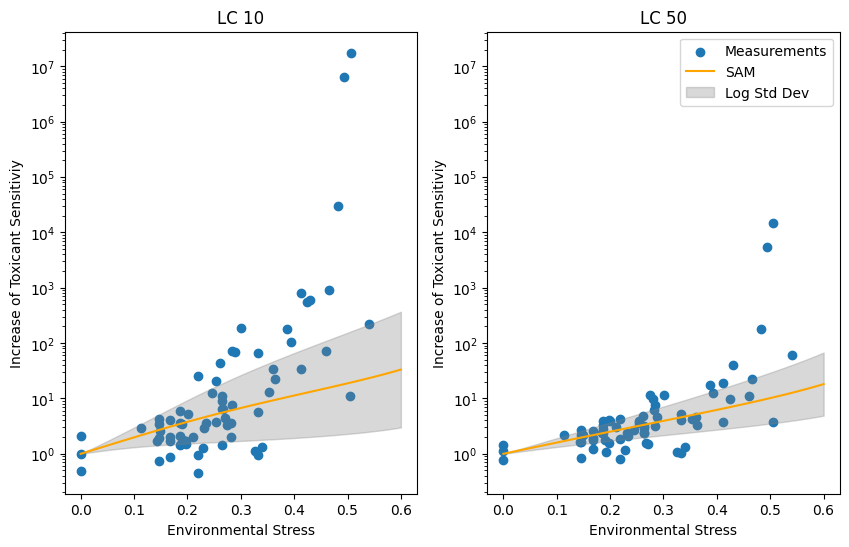

In [12]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")

plt.scatter(df.stress_level, df["true_10_frac"], label = "Measurements")
ax1.plot(stresses, mean_curve_10, color='orange', label='SAM')
ax1.fill_between(stresses, lower_curve_10, upper_curve_10, color='gray', alpha=0.3, label='Log Std Dev')


plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")

plt.scatter(df.stress_level, df["true_50_frac"], label = "Measurements")

plt.plot(stresses, mean_curve_50, color='orange', label='SAM')
plt.fill_between(stresses, lower_curve_50, upper_curve_50, color='gray', alpha=0.3, label='Log Std Dev')

plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.legend()
plt.show()

In [85]:
df.head()
cleaned = df.copy()
cleaned.days = cleaned.days.astype(int)
cleaned

,title,days,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50,experiment_name,true_10_frac,true_50_frac,stress_level
0,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,21.160992,121.663121,10.619750,40.123378,4.200062,48.950581,"2021 Ayesha-Cloth, °C, Adap",1.992607,3.032225,0.210847
1,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_24,21.160992,121.663121,5.688399,34.417837,1.785952,31.920146,"2021 Ayesha-Cloth, °C, Adap",3.720026,3.534886,0.254125
2,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,22.782208,273.906351,15.299308,82.774076,2.384012,95.515601,"2021 Ayesha-Cloth, °C, Adap",1.489101,3.309084,0.187176
3,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_24,22.782208,273.906351,6.967444,23.884589,0.195967,30.311430,"2021 Ayesha-Cloth, °C, Adap",3.269809,11.467911,0.274121
4,/home/felix/Desktop/sam/data/2021 Ayesha-Cloth...,2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_20,19.641084,164.031159,13.815343,70.003551,2.411228,53.875106,"2021 Ayesha-Cloth, °C, Adap",1.421686,2.343183,0.185333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"/home/felix/Desktop/sam/data/2024 Naeem-2Tox, ...",2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_19 + Prochloraz_1,18.740966,141.857687,6.342790,65.847496,3.703880,66.127490,"2024 Naeem-2Tox, °C, Adapt",2.954688,2.154337,0.113728
65,"/home/felix/Desktop/sam/data/2024 Naeem-2Tox, ...",2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_19 + Prochloraz_10,18.740966,141.857687,6.323169,59.093506,0.523325,27.336548,"2024 Naeem-2Tox, °C, Adapt",2.963857,2.400563,0.231586
66,"/home/felix/Desktop/sam/data/2024 Naeem-2Tox, ...",2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_22,18.740966,141.857687,5.285231,49.952494,1.112768,38.909801,"2024 Naeem-2Tox, °C, Adapt",3.545912,2.839852,0.185753
67,"/home/felix/Desktop/sam/data/2024 Naeem-2Tox, ...",2,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_22 + Prochloraz_1,18.740966,141.857687,3.518699,36.124656,0.872357,34.814020,"2024 Naeem-2Tox, °C, Adapt",5.326107,3.926894,0.200334


In [13]:
def create_plotly_fig(y_col, mean_curve, lower, upper, title):

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=stresses, y=mean_curve, mode="lines", line=dict(color="orange"), name="SAM"
        )
    )

    # Shaded area for log std dev
    fig.add_trace(
        go.Scatter(
            x=stresses.tolist()
            + stresses[::-1].tolist(),  # x values need to loop back for shading
            y=upper.tolist()
            + lower[::-1].tolist(),  # Upper curve followed by reversed lower curve
            fill="toself",
            fillcolor="gray",
            opacity=0.3,
            line=dict(color="gray"),
            name="Log Std Dev",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=cleaned["stress_level"],
            y=cleaned[y_col],
            mode="markers",
            name="LC 10",
            customdata=cleaned[
                [
                    "experiment_name",
                    "stress_name",
                    "days",
                    "chemical",
                    "organism",
                    "stress_level",
                ]
            ],
            hovertemplate="<b>Experiment</b>: %{customdata[0]}<br>"
            + "<b>Additional Stressor</b>: %{customdata[1]}<br>"
            + "<b>Duration</b>: %{customdata[2]}<br>"
            + "<b>Main Stressor</b>: %{customdata[3]}<br>"
            + "<b>Organism</b>: %{customdata[4]}<br>"
            + "<b>Additional Stress Level</b>: %{customdata[5]:.2f}<extra></extra>",
        )
    )

    cleaner = {"days": "Duration", "organism": "Organism", "experiment_name": "Experiment"}
    additional_stuff = sum(len(cleaned[x].unique()) for x in cleaner)

    buttons = [dict(label="All", method="update", args=[{"visible": [True, True,True] + [False] * additional_stuff}])]

    counter = 0
    for key, label_name in cleaner.items():
        for val in df[key].unique():
            mask = df[key] == val
            fig.add_trace(go.Scatter(
                x=df[mask]['stress_level'],
                y=df[mask]['true_10_frac'],
                mode='markers',
                name=f"{label_name} = {val}",
                visible=True,  # All traces start visible
                customdata=df[mask][['experiment_name', 'stress_name', 'days', 'chemical', 'organism']],
                hovertemplate='<b>Experiment</b>: %{customdata[0]}<br>' +
                                '<b>Additional Stressor</b>: %{customdata[1]}<br>' +
                                '<b>Duration</b>: %{customdata[2]}<br>' +
                                '<b>Main Stressor</b>: %{customdata[3]}<br>' +
                                '<b>Organism</b>: %{customdata[4]}<extra></extra>'
            ))
            
            
            visible = [True, True, False] + list(np.arange(additional_stuff) == counter)
            buttons.append(dict(label=f"{label_name} = {val}", method="update", args=[{"visible": visible}]))
            
            counter += 1


    fig.update_layout(
        title = title,
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
            ),
        ],
        yaxis_type="log",
        xaxis_title=x_name,
        yaxis_title=y_name,
    )
    return fig
lc_10_fig = create_plotly_fig("true_10_frac", mean_curve_10, lower_curve_10, upper_curve_10, "LC 10")
lc_50_fig = create_plotly_fig("true_50_frac", mean_curve_50, lower_curve_50, upper_curve_50, "LC 50")

NameError: name 'cleaned' is not defined

In [129]:
lc_10_fig.write_html("control_imgs/plotly/lc10.html")
lc_50_fig.write_html("control_imgs/plotly/lc50.html")

# Read both HTML files
with open("control_imgs/plotly/lc10.html", "r") as file1, open("control_imgs/plotly/lc50.html", "r") as file2:
    lc10_html = file1.read()
    lc50_html = file2.read()

# Extract the <div> and <script> contents for each figure
lc10_content = lc10_html.split("<body>")[1].split("</body>")[0]
lc50_content = lc50_html.split("<body>")[1].split("</body>")[0]

# Create a new HTML file with combined content
with open("control_imgs/plotly/combined_lc.html", "w") as combined_file:
    combined_file.write("<html><head><meta charset='utf-8' /></head><body>")
    combined_file.write(lc10_content)  # First figure's content
    combined_file.write("<br><hr><br>")  # Optional line break and separator
    combined_file.write(lc50_content)  # Second figure's content
    combined_file.write("</body></html>")

In [64]:
cords = np.stack((df.stress_level, np.log10(df["true_10_frac"])), -1)
cords /= cords.max(0)[None,:]

distances = np.sqrt(np.square(cords[None,:] - cords[:,None]).sum(-1))
np.fill_diagonal(distances, np.inf)
groups = []
done = set()

CUT = 0.03

while sum(map(len,groups)) != len(cords):
    new_group = []
    
    for i, dist in enumerate(distances):
        if i in done:
            continue
        
        if new_group and any(dist[j] < CUT for j in new_group):
            m = min([dist[j] < CUT for j in new_group])
            continue
        
        new_group.append(i)
        done.add(i)
    groups.append(new_group)

len(groups)

5

In [ ]:
distances[27]

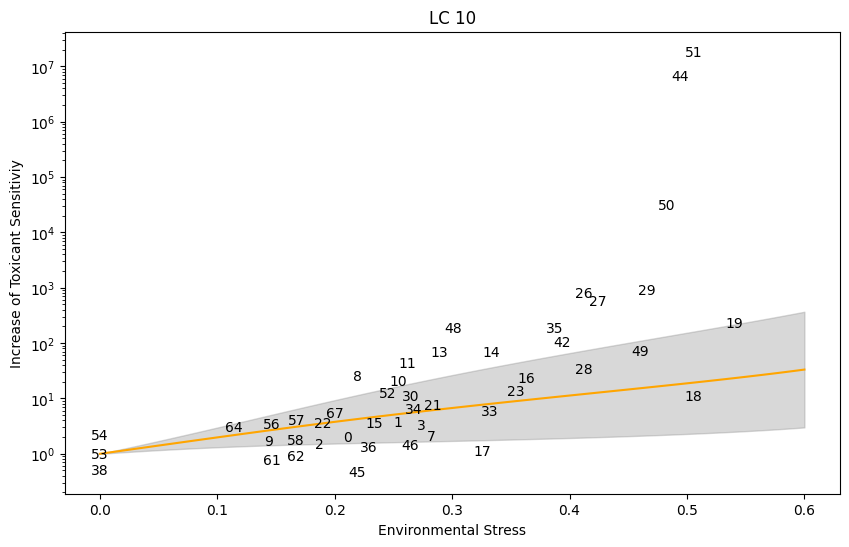

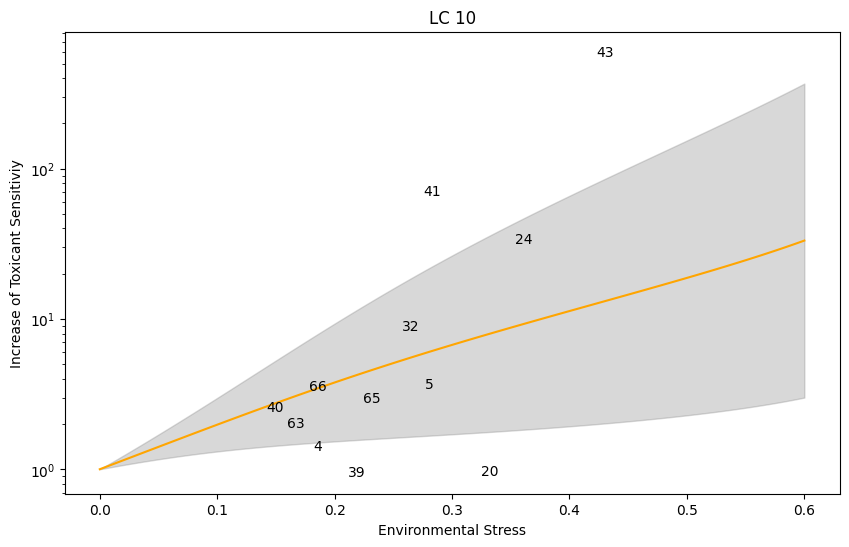

In [75]:
def plot_ids(ids : list[int]):
    plt.figure(figsize=(10, 6))

    plt.title("LC 10")
    for i, (idx, row) in enumerate(df.iterrows()):
        if i not in ids:
            continue
        plt.text(row.stress_level, row["true_10_frac"], str(i), ha="center", va="center")
        plt.scatter(row.stress_level, row["true_10_frac"], alpha= 0)

    plt.plot(stresses, mean_curve_10, color='orange', label='SAM')
    plt.fill_between(stresses, lower_curve_10, upper_curve_10, color='gray', alpha=0.3, label='Log Std Dev')
    plt.yscale("log")
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()
plot_ids(groups[0])
plot_ids(groups[1])


In [ ]:
interest  = [
    ("liess_copper_2001", "Food_1% + UV"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_100"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_32"),
    ("naeem_Esfenvalerate_2024", "Food_1% + Temp_25"),
    ("naeem_Mix13_2024", "Temp_25 + Food_1%")
]

mask = df.apply(lambda x: any(path in x.title and stress in x.stress_name for path, stress in interest), axis = 1)

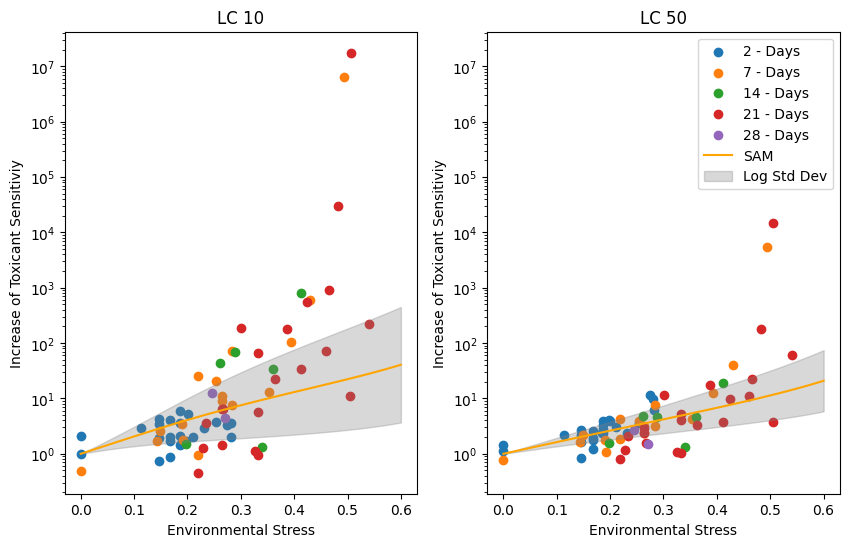

In [25]:
plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")


for days, sub in df.groupby("days"):


    plt.scatter(sub.stress_level, sub["true_10_frac"], label = "{} - Days".format(int(days)))


ax1.plot(stresses, mean_curve_10, color='orange', label='SAM')
ax1.fill_between(stresses, lower_curve_10, upper_curve_10, color='gray', alpha=0.3, label='Log Std Dev')


plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")

for days, sub in df.groupby("days"):


    plt.scatter(sub.stress_level, sub["true_50_frac"], label = "{} - Days".format(int(days)))

plt.plot(stresses, mean_curve_50, color='orange', label='SAM')
plt.fill_between(stresses, lower_curve_50, upper_curve_50, color='gray', alpha=0.3, label='Log Std Dev')

plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.legend()
plt.show()

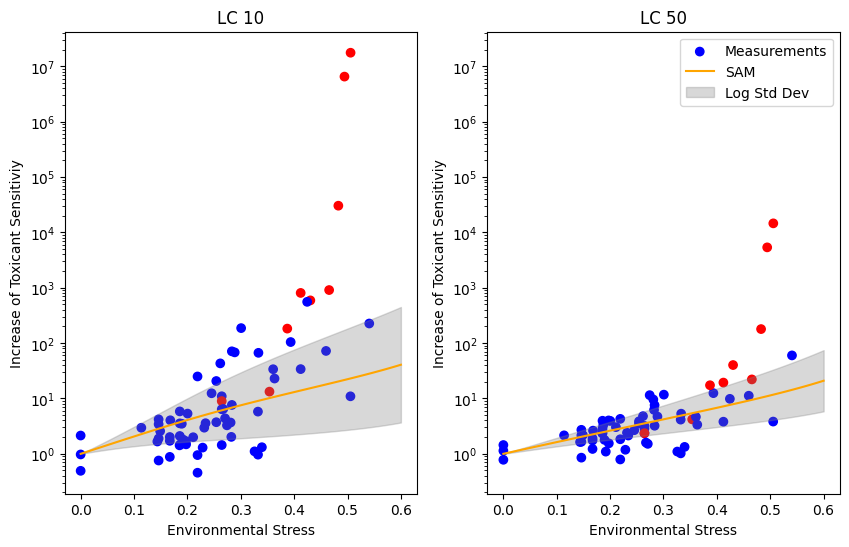

In [24]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50


log_lc10 = [np.log(ar[0] / ar) for ar in lc10]
log_lc50 = [np.log(ar[0] / ar) for ar in lc50]

# Calculate the mean and std in the log-space
log_mean_curve_10 = np.mean(log_lc10, axis=0)
log_std_curve_10 = np.std(log_lc10, axis=0)

log_mean_curve_50 = np.mean(log_lc50, axis=0)
log_std_curve_50 = np.std(log_lc50, axis=0)

# Exponentiate back to the original scale
mean_curve_10 = np.exp(log_mean_curve_10)
upper_curve_10 = np.exp(log_mean_curve_10 + log_std_curve_10)
lower_curve_10 = np.exp(log_mean_curve_10 - log_std_curve_10)

mean_curve_50 = np.exp(log_mean_curve_50)
upper_curve_50 = np.exp(log_mean_curve_50 + log_std_curve_50)
lower_curve_50 = np.exp(log_mean_curve_50 - log_std_curve_50)



df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")

color = ["blue" if not i else "red" for i in mask]

plt.scatter(df.stress_level, df["true_10_frac"], label = "Measurements", color = color)


ax1.plot(stresses, mean_curve_10, color='orange', label='SAM')
ax1.fill_between(stresses, lower_curve_10, upper_curve_10, color='gray', alpha=0.3, label='Log Std Dev')


plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")

plt.scatter(df.stress_level, df["true_50_frac"], label = "Measurements", color = color)

plt.plot(stresses, mean_curve_50, color='orange', label='SAM')
plt.fill_between(stresses, lower_curve_50, upper_curve_50, color='gray', alpha=0.3, label='Log Std Dev')

plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.legend()
plt.show()

In [12]:
df.columns

Index(['title', 'chemical', 'organism', 'main_fit', 'stress_fit',
       'stress_name', 'main_lc10', 'main_lc50', 'stress_lc10', 'stress_lc50',
       'sam_lc10', 'sam_lc50', 'true_10_frac', 'true_50_frac', 'stress_level'],
      dtype='object')

In [13]:
a = df.loc[~mask].copy()
a["true_10_frac"] = a.main_lc10 / a.stress_lc10

a["nn"] = a.apply( lambda x: x.title.replace("/home/felix/Desktop/sam/data/", "") + "_" + x.stress_name, axis=1)

a.sort_values("true_10_frac", ascending=False).nn.values

array(['naeem_Mix13_2024/21_days._Food_1%',
       'lies_coppper_2001/data._Food_1% + UV',
       'naeem_Esfenvalerate_2019/21_days._Food_1%',
       'naeem_Esfenvalerate_2019/7_days._Food_1% + Prochloraz_1',
       'naeem_Esfenvalerate_2019/21_days._Food_1% + Prochloraz_1',
       'naeem_Esfenvalerate_2019/7_days._Food_1%',
       'bps_2019/14_days._Esfenvalerate + Food_1%',
       'bps_2019/21_days._Food_1%', 'bps_2019/14_days._Food_1%',
       'naeem_Mix13_2024/21_days._Temp_25',
       'naeem_Mix13_2024/14_days._Food_1%', 'bps_2019/7_days._Food_1%',
       'bps_2019/21_days._Esfenvalerate + Food_1%',
       'bps_2019/7_days._Esfenvalerate + Food_1%',
       'huang_Imidachloprid_2023/data._Temp_15',
       'naeem_Esfenvalerate_2024/7_days._Food_1%',
       'lies_coppper_2001/data._UV', 'naeem_Mix13_2024/7_days._Food_1%',
       'naeem_Esfenvalerate_2024/21_days._Temp_25',
       'naeem_Esfenvalerate_2019/21_days._Prochloraz_100',
       'naemm_Clothianidin_2024/agriculture._Temp_22 